# import modules
- numpy: array manipulation & math operations
- random: randomly generate cities
- matplotlib: visualize cities & paths
- typing: simpler code reading

In [ ]:
# Uncomment and run if needed
# !pip install numpy
# !pip install matplotlib

In [ ]:
from typing import Dict, Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import random

# helper functions


In [ ]:
def generate_cities(n: int) -> Dict[int, Tuple[float, float]]:
    """Generate a dictionary of n cities with random coordinates"""
    return { i: (random.uniform(0, 100), random.uniform(0, 100)) for i in range(n) }

def distance(city1: Tuple[float, float],
             city2: Tuple[float, float]) -> float:
    """Calculate Euclidean distance between two cities"""
    city1_x, city1_y = city1
    city2_x, city2_y = city2
    return np.sqrt((city1_x - city2_x)**2 + (city1_y - city2_y)**2)

def calc_tour_length(tour: List[int],
                     cities: Dict[int, Tuple[float, float]]) -> float:
    """Calculate total length of a tour"""
    return sum([distance(cities[tour[i]], cities[tour[i+1]]) for i in range(len(tour)-1)])

def generate_dist_matrix(cities: Dict[int, Tuple[float, float]]) -> np.ndarray:
    """Generate distance matrix for all cities"""
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = distance(cities[i], cities[j])
    return dist_matrix

def initialize_pheromones(n_cities: int,
                          initial_value: float = 1.0) -> np.ndarray:
    """Initialize pheromone matrix with initial_value on non-diagonal elements"""
    ph_matrix = np.ones((n_cities, n_cities)) * initial_value
    np.fill_diagonal(ph_matrix, 0)  # No pheromone on diagonal (same city)
    return ph_matrix

def normalize_probabilities(probabilities: np.ndarray) -> np.ndarray:
    """Normalize probabilities to sum to 1"""
    prob_sum = sum(probabilities)
    if prob_sum == 0:
        return [1/len(probabilities)] * len(probabilities)
    return [p/prob_sum for p in probabilities]


In [ ]:
def plot_city_tour(cities: Dict[int, Tuple[float, float]],
                   tour: list[int] = None,
                   tour_length: int = None,
                   title: str = None) -> None:
    """
    Plot cities as a scatter plot. If tour is given, plot the
    tour paths as arrows.
    """
    x = [city[0] for city in cities.values()]
    y = [city[1] for city in cities.values()]

    plt.figure()
    plt.scatter(x, y, c='blue', s=50)

    if title:
        plt.title(title)
    else:
        plt.title('City')

    if tour is not None:
        start = tour[0]
        end = tour[-1]
        start_x, start_y = cities[start]
        end_x, end_y = cities[end]
        plt.scatter(start_x, start_y, c='red', s=50, label='Start') # Color the start of the tour
        plt.scatter(end_x, end_y, c='purple', s=50, label='End')    # Color the end of the tour

        for i in range(len(tour)-1):
            city1 = tour[i]
            city2 = tour[i+1]
            city1_x, city1_y = cities[city1]
            city2_x, city2_y = cities[city2]
            plt.arrow(city1_x, city1_y, city2_x-city1_x, city2_y-city1_y,
                    head_width=1, head_length=2, fc='black', ec='black', length_includes_head=True)

        if tour_length is None:
            tour_length = calc_tour_length(tour, cities)

        plt.text(0.02, 0.02, f"Tour length: {tour_length:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

        plt.legend(loc='lower right')

    plt.axis('off')
    plt.show()

# nearest neighbor heuristic

In [ ]:
def nearest_neighbor(cities: Dict[int, Tuple[float, float]],
                     dist_matrix: np.ndarray = None,
                     start_city: int = None,
                     verbose: bool = True) -> np.ndarray:
    """Nearest neighbor heuristic for TSP"""
    curr = start_city if start_city is not None else random.choice(list(cities.keys()))
    tour = [curr]
    unvisited = list(cities.keys())
    unvisited.remove(curr)

    if dist_matrix is None:
        dist_matrix = generate_dist_matrix(cities)

    while unvisited:
        nearest = min(unvisited, key=lambda city: dist_matrix[curr][city])
        tour.append(nearest)
        unvisited.remove(nearest)
        curr = nearest

    tour_length = calc_tour_length(tour, cities)

    if verbose:
        print(f"Nearest neighbor tour length starting at city {start_city}: {tour_length:.2f}")
        print('===================================================================')


    return tour, tour_length

# ant colony optimization algorithm (and helper functions)

In [ ]:
def ant_colony_opt(cities: Dict[int, Tuple[float, float]],
                dist_matrix: np.ndarray = None,
                start_city: int = None,
                num_ants: int = 10,
                num_iterations: int = 20,
                alpha: float = 1,
                beta: float = 2,
                rho: float = 0.5,
                Q: float = 100,
                elitist: bool = False,
                min_pheromone: float = 0.01,
                max_pheromone: float = 10.0,
                verbose: bool = True,
                conv_graph: bool = True) -> Tuple[List[int], float]:
    """ Ant Colony Optimization for TSP """
    n_cities = len(cities)

    # Precompute distance matrix for efficiency
    if dist_matrix is None:
        dist_matrix = generate_dist_matrix(cities)

    # Initialize pheromones
    ph_matrix = initialize_pheromones(n_cities)

    # Initialize other data
    best_tour = None
    best_tour_length = float('inf')
    convergence_data = []

    for iteration in range(num_iterations):
        tours = []
        tour_lengths = []

        # Let each ant construct a tour
        for ant in range(num_ants):
            # Start from random city
            curr = random.choice(list(cities.keys()))
            tour = [curr]
            unvisited = list(cities.keys())
            unvisited.remove(curr)

            while unvisited:
                # Calculate probabilities for next city
                probabilities = []
                for next_city in unvisited:
                    ph = ph_matrix[curr][next_city]
                    h = 1 / dist_matrix[curr][next_city]
                    probabilities.append((ph ** alpha) * (h ** beta))

                # Normalize probabilities
                prob_sum = normalize_probabilities(probabilities)

                # Select next city
                next_city = random.choices(unvisited, weights=probabilities, k=1)[0]
                tour.append(next_city)
                unvisited.remove(next_city)
                curr = next_city

            # Complete the tour by returning to start
            tour_length = calc_tour_length(tour, cities)
            tours.append(tour)
            tour_lengths.append(tour_length)

            # Update global best
            if tour_length < best_tour_length:
                best_tour = tour.copy()
                best_tour_length = tour_length
                if verbose:
                    print(f"Iteration {iteration}, ant {ant}: New best tour length = {best_tour_length:.2f}")

        # Update pheromones (Evaporation)
        ph_matrix *= (1 - rho)

        # Apply pheromone limits
        ph_matrix = np.clip(ph_matrix, min_pheromone, max_pheromone)

        # Deposit pheromones
        for tour, length in zip(tours, tour_lengths):
            delta_ph = Q / length
            for i in range(n_cities-1):
                ph_matrix[tour[i]][tour[i+1]] += delta_ph

        # Elitist strategy: extra pheromone for best tour
        if elitist and best_tour is not None:
            delta_ph = Q / best_tour_length
            for i in range(n_cities-1):
                ph_matrix[best_tour[i]][best_tour[i+1]] += delta_ph

        convergence_data.append(best_tour_length)

    # Plot convergence if verbose
    if conv_graph:
        plt.figure(figsize=(10, 5))
        plt.plot(convergence_data)
        plt.title("ACO Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Best Tour Length")
        plt.grid(True)
        plt.show()

    return best_tour, best_tour_length, convergence_data

# Experimentation


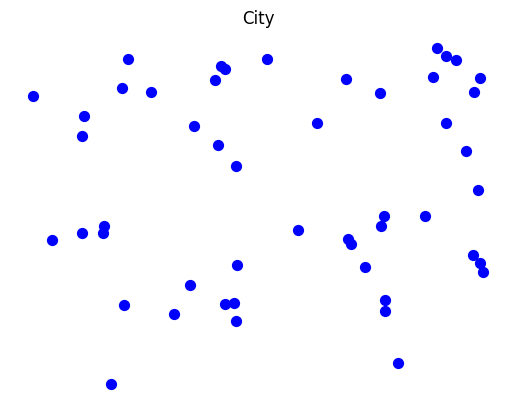

In [ ]:
""" Constants initialization """

# Initialize constants
n_cities = 50

# Generate city list
cities_1 = generate_cities(n_cities)

# Generate distance matrix
dist_matrix_1 = generate_dist_matrix(cities_1)

# Plot cities
plot_city_tour(cities_1)

Best Nearest Neighbor Tour length: 535.31
Worse Nearest Neighbor Tour length: 652.77
Average Nearest Neighbor Tour length: 605.11


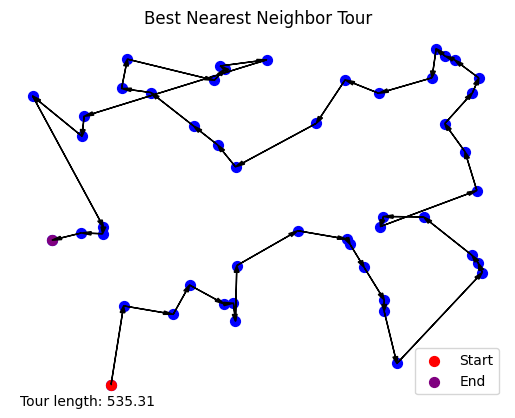

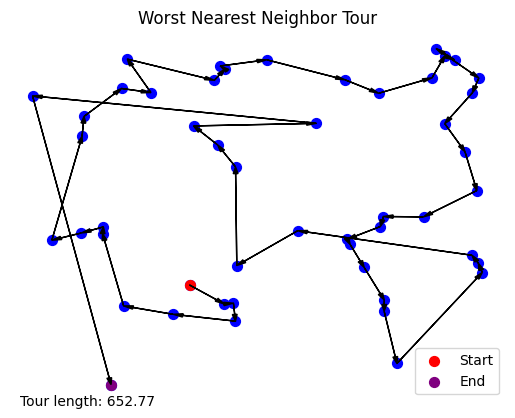

Iteration 0, ant 0: New best tour length = 1170.19
Iteration 0, ant 2: New best tour length = 1064.56
Iteration 0, ant 3: New best tour length = 993.29
Iteration 0, ant 4: New best tour length = 956.49
Iteration 1, ant 7: New best tour length = 927.27
Iteration 1, ant 16: New best tour length = 914.57
Iteration 2, ant 3: New best tour length = 881.16
Iteration 2, ant 4: New best tour length = 790.71
Iteration 2, ant 23: New best tour length = 757.02
Iteration 3, ant 8: New best tour length = 739.65
Iteration 3, ant 14: New best tour length = 692.01
Iteration 4, ant 29: New best tour length = 686.28
Iteration 5, ant 9: New best tour length = 634.35
Iteration 5, ant 20: New best tour length = 617.17
Iteration 7, ant 3: New best tour length = 583.22
Iteration 9, ant 0: New best tour length = 560.78
Iteration 15, ant 0: New best tour length = 560.71
Iteration 16, ant 3: New best tour length = 560.42
Iteration 22, ant 29: New best tour length = 543.11


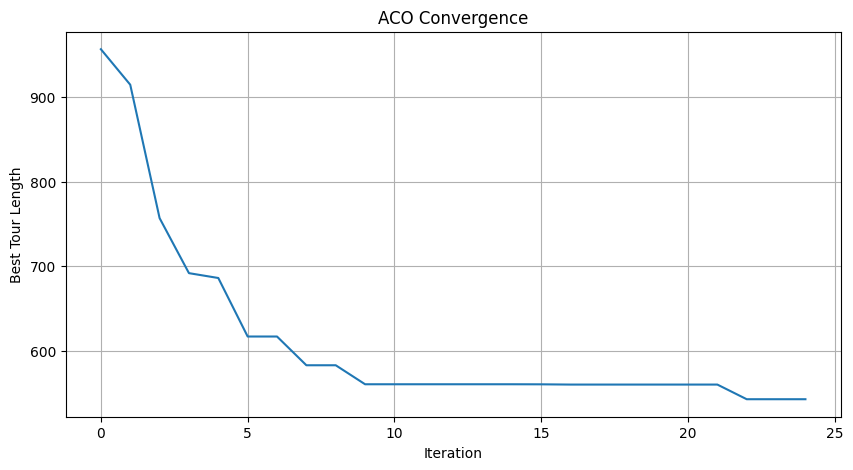

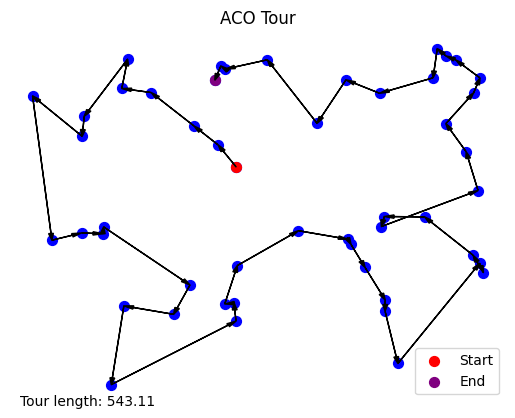

Nearest neighbor is better by 1.46%
ACO converged at iteration 22


In [ ]:
""" Nearest neighbor / ACO comparison """

# Save nearest neighbor tours
nn_tours = []

# Complete nearest neighbor with each city as the starting city and save it
for i in range(n_cities):
    nn_tour, nn_tour_length = nearest_neighbor(cities_1, dist_matrix_1, start_city=i, verbose=False)
    nn_tours.append((nn_tour, nn_tour_length))

# Record and display best, worst, and mean graphs and statistics
best_nn_tour, best_nn_tour_length = min(nn_tours, key=lambda x: x[1])
worst_nn_tour, worst_nn_tour_length = max(nn_tours, key=lambda x: x[1])
mean_nn_tour_length = np.mean([x[1] for x in nn_tours])

print(f"Best Nearest Neighbor Tour length: {best_nn_tour_length:.2f}")
print(f"Worse Nearest Neighbor Tour length: {worst_nn_tour_length:.2f}")
print(f"Average Nearest Neighbor Tour length: {mean_nn_tour_length:.2f}")
print('===================================================================')

plot_city_tour(cities_1, best_nn_tour, best_nn_tour_length, title='Best Nearest Neighbor Tour')
plot_city_tour(cities_1, worst_nn_tour, worst_nn_tour_length, title='Worst Nearest Neighbor Tour')
print('===================================================================')

aco_tour, aco_tour_length, aco_convergence = ant_colony_opt(cities_1, dist_matrix_1, num_ants=30, num_iterations=25)
print('===================================================================')
plot_city_tour(cities=cities_1, tour=aco_tour, tour_length=aco_tour_length, title='ACO Tour')

if (best_nn_tour_length < aco_tour_length):
    percent_diff = (aco_tour_length - best_nn_tour_length) / best_nn_tour_length * 100
    print(f"Nearest neighbor is better by {percent_diff:.2f}%")
else:
    percent_diff = (best_nn_tour_length - aco_tour_length) / aco_tour_length * 100
    print(f"Ant colony optimization is better by {percent_diff:.2f}%")

converged = aco_convergence.index(aco_convergence[-1])

print('===================================================================')
print(f"ACO converged at iteration {converged}")

In [ ]:
""" NN / ACO deep comparison """

# Init comparison constant
n_comparisons = 50

# Init relevant data
nn_better_rate = 0
aco_better_rate = 0
nn_tour_lengths = []
aco_tour_lengths = []
nn_percent_diffs = []
aco_percent_diffs = []

# Compare which algorithm is better over n_comparisons
for _ in range(n_comparisons):
    cities_2 = generate_cities(n_cities)
    dist_matrix_2 = generate_dist_matrix(cities_2)

    nn_tours = []
    for i in range(n_cities):
        nn_tour, nn_tour_length = nearest_neighbor(cities_2, dist_matrix_2, start_city=i, verbose=False)
        nn_tours.append((nn_tour, nn_tour_length))

    best_nn_tour, best_nn_tour_length = min(nn_tours, key=lambda x: x[1])
    aco_tour, aco_tour_length, aco_convergence = ant_colony_opt(cities_2, dist_matrix_2, num_ants=30, num_iterations=25, verbose=False, conv_graph=False)

    nn_tour_lengths.append(best_nn_tour_length)
    aco_tour_lengths.append(aco_tour_length)

    if (best_nn_tour_length < aco_tour_length):
        percent_diff = (aco_tour_length - best_nn_tour_length) / best_nn_tour_length * 100
        nn_percent_diffs.append(percent_diff)
        nn_better_rate += 1
    else:
        percent_diff = (best_nn_tour_length - aco_tour_length) / aco_tour_length * 100
        aco_percent_diffs.append(percent_diff)
        aco_better_rate += 1

nn_tour_better_rate = nn_better_rate / n_comparisons * 100
aco_tour_better_rate = aco_better_rate / n_comparisons * 100

nn_tour_mean_percent_diff = np.mean(nn_percent_diffs)
aco_tour_mean_percent_diff = np.mean(aco_percent_diffs)

nn_tour_mean = np.mean(nn_tour_lengths)
aco_tour_mean = np.mean(aco_tour_lengths)

# Display relevant statistics
print(f"Over {n_comparisons} comparisons:")
print(f"Nearest neighbor was better {nn_tour_better_rate:.2f}% of the time by {nn_tour_mean_percent_diff:.2f}% with a mean length of {nn_tour_mean:.2f}")
print(f"Ant colony optimization was better {aco_tour_better_rate}% of the time by {aco_tour_mean_percent_diff:.2f}% with a mean length of {aco_tour_mean:.2f}")

Over 50 comparisons:
Nearest neighbor was better 46.00% of the time by 1.67% with a mean length of 574.74
Ant colony optimization was better 54.0% of the time by 2.55% with a mean length of 571.31


In [ ]:
""" Elitist strategy deep comparison """

# Init comparison constant
n_comparisons = 15

# Init ant/iter values
num_ants = 10
num_iterations = 25

# Save the tours
aco_tours = []
elite_tours = []

# Init relevant data
aco_better = 0
elite_better = 0
aco_faster = 0
elite_faster = 0

# Compare which algorithm is better over n_comparisons
for iter in range(n_comparisons):
    cities_3 = generate_cities(n_cities)
    dist_matrix_3 = generate_dist_matrix(cities_3)

    aco_tour, aco_tour_length, aco_convergence = ant_colony_opt(
        cities=cities_3,
        dist_matrix=dist_matrix_3,
        verbose=False,
        conv_graph=False,
        elitist=False,
        num_ants=num_ants,
        num_iterations=num_iterations
    )

    elitistaco_tour, elitistaco_tour_length, elitist_convergence = ant_colony_opt(
        cities=cities_3,
        dist_matrix=dist_matrix_3,
        verbose=False,
        conv_graph=False,
        elitist=True,
        num_ants=num_ants,
        num_iterations=num_iterations
    )

    aco_tours.append((aco_tour, aco_tour_length))
    elite_tours.append((elitistaco_tour, elitistaco_tour_length))

    if (aco_tour_length < elitistaco_tour_length):
        aco_better += 1
    else:
        elite_better += 1

    aco_converged = aco_convergence.index(aco_convergence[-1])
    elite_converged = elitist_convergence.index(elitist_convergence[-1])

    if (aco_converged < elite_converged):
        aco_faster += 1
    else:
        elite_faster += 1

aco_better_rate = aco_better / n_comparisons * 100
elite_better_rate = elite_better / n_comparisons * 100

aco_tour_mean = np.mean([x[1] for x in aco_tours])
elite_tour_mean = np.mean([x[1] for x in elite_tours])

aco_faster_rate = aco_faster / n_comparisons * 100
elite_faster_rate = elite_faster / n_comparisons * 100

# Display relevant statistics
print(f"Over {n_comparisons} comparisons:")
print(f"AS was better {aco_better_rate:.2f}% of the time with a mean length of {aco_tour_mean:.2f}")
print(f"EA was better {elite_better_rate:.2f}% of the time with a mean length of {elite_tour_mean:.2f}")
print(f"AS converged faster {aco_faster_rate}% of the time")
print(f"EA converged faster {elite_faster_rate}% of the time")
print('===================================================================')

Over 15 comparisons:
AS was better 40.00% of the time with a mean length of 612.32
EA was better 60.00% of the time with a mean length of 600.55
AS converged faster 53.333333333333336% of the time
EA converged faster 46.666666666666664% of the time


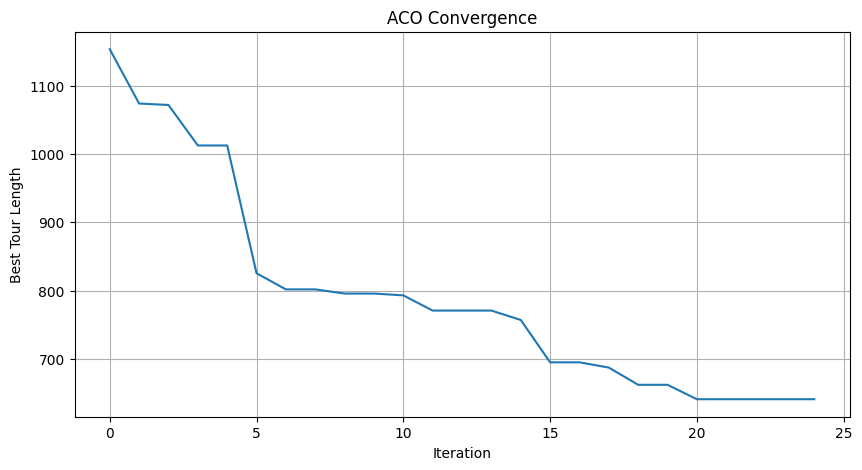

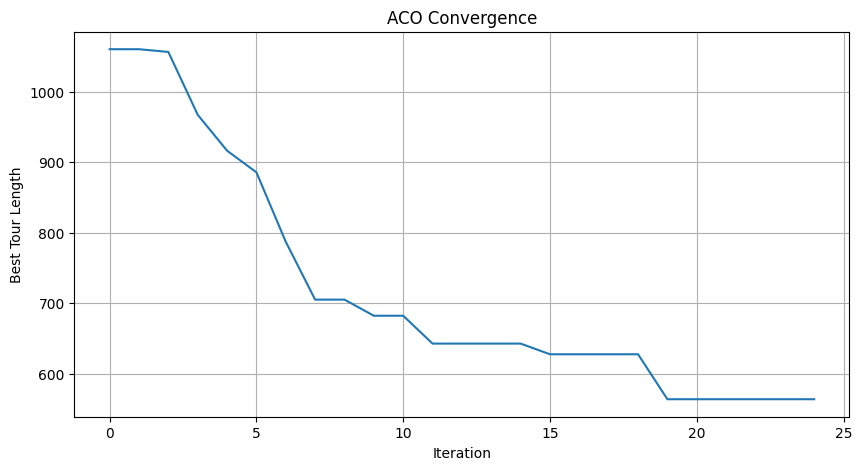

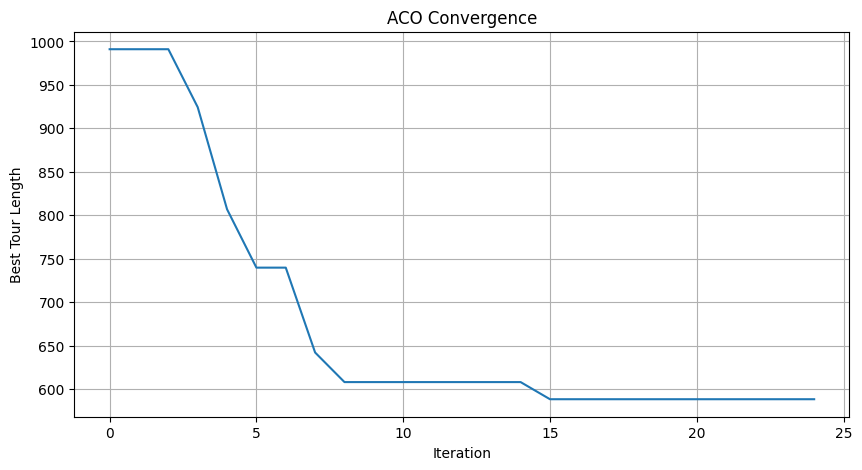

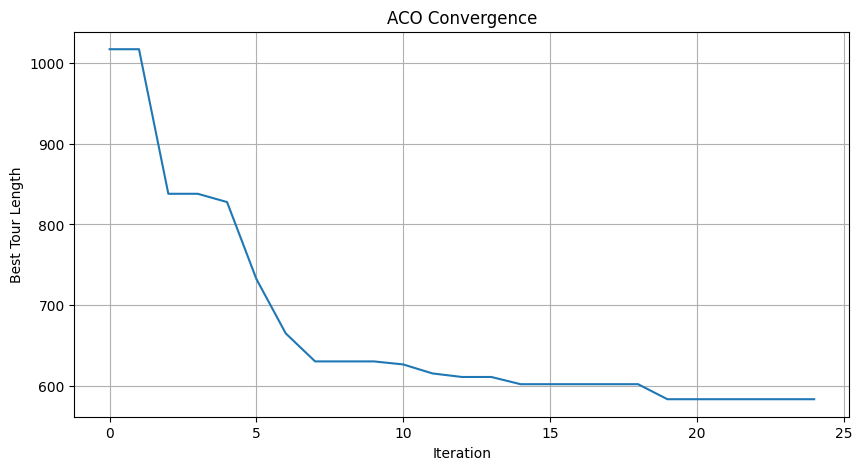

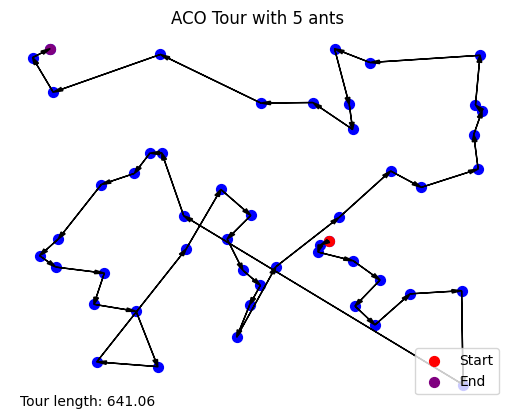

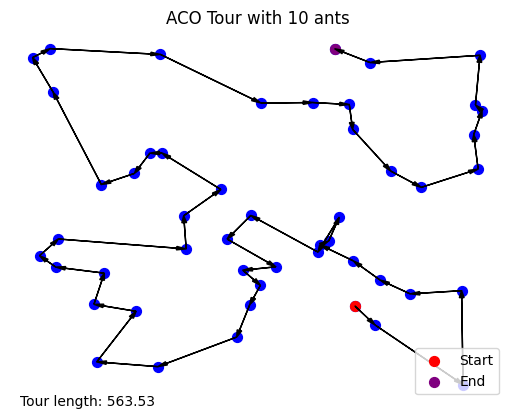

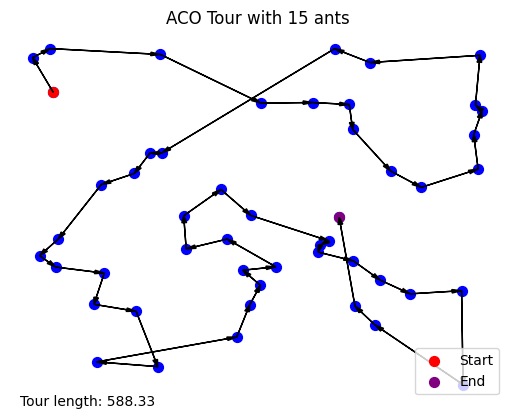

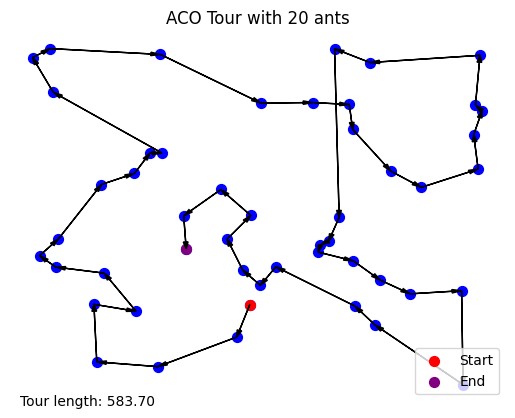

In [ ]:
""" Number of ants comparison """

# Generate new city
cities_4 = generate_cities(n_cities)
dist_matrix_4 = generate_dist_matrix(cities_4)

# Compare algorithm over number of ants
aco_tour_1, aco_tour_length_1, aco_convergence_1 = ant_colony_opt(cities=cities_4, dist_matrix=dist_matrix_4, verbose=False, num_ants=5, num_iterations=25)
aco_tour_2, aco_tour_length_2, aco_convergence_2 = ant_colony_opt(cities=cities_4, dist_matrix=dist_matrix_4, verbose=False, num_ants=10, num_iterations=25)
aco_tour_3, aco_tour_length_3, aco_convergence_3 = ant_colony_opt(cities=cities_4, dist_matrix=dist_matrix_4, verbose=False, num_ants=15, num_iterations=25)
aco_tour_4, aco_tour_length_4, aco_convergence_4 = ant_colony_opt(cities=cities_4, dist_matrix=dist_matrix_4, verbose=False, num_ants=20, num_iterations=25)

# Display graphs
plot_city_tour(cities_4, aco_tour_1, aco_tour_length_1, title='ACO Tour with 5 ants')
plot_city_tour(cities_4, aco_tour_2, aco_tour_length_2, title='ACO Tour with 10 ants')
plot_city_tour(cities_4, aco_tour_3, aco_tour_length_3, title='ACO Tour with 15 ants')
plot_city_tour(cities_4, aco_tour_4, aco_tour_length_4, title='ACO Tour with 20 ants')